The primary objective of this competition is to employ deep learning-based regression models, such as Convolutional Neural Networks (CNNs) like ConvNext or Transformers, to predict plant traits from photographs. These plant traits, although available for each image, may not yield exceptionally high accuracies due to the inherent heterogeneity of citizen science data. The various plant traits describe chemical tissue properties that are loosely related to the visible appearance of plants in images. Despite the anticipated moderate accuracies, the overarching goal is to explore the potential of this approach and gain insights into global changes affecting ecosystems. Your contribution to uncovering the wealth of data and the distribution of plant traits worldwide is invaluable.

Our goal is to predict a broad set of 6 plant traits (e.g. leaf area, plant height) from crowd-sourced plant images and some ancillary data. 

The models will be evaluated against the independent test data. The evaluation metric for this competition is the mean R2 over all 6 traits. The R2 is commonly used for evaluating regression models and is the ratio of the sum of squares the residuals (SSres) to the total sum of squares (SStot).

The R2 can result in large negative values. To prevent that we will only consider R2 values > 0.

The submission should include a .csv file with a prediction for each trait and the following columns: id (see labels) and a prediction for each trait (X1080, X50, …). An example is given with sample_submission.csv


In [2]:
#imports and variables
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

DATA_DIR = os.getcwd() +'/data/' #data directory kaggle: /kaggle/input/planttraits2024/

In [21]:
class CONFIG:
    sub = f"{DATA_DIR}sample_submission.csv"
    trgts = f"{DATA_DIR}target_name_meta.tsv"
    train_path = f"{DATA_DIR}train.csv"
    test_path = f"{DATA_DIR}test.csv"
    train_image_path = f"{DATA_DIR}train_images/"
    test_image_path = f"{DATA_DIR}test_images/"
    SEED = 42 #seed for reproducibility
    IMAGE_SIZE = [224, 224] 
    BATCH_SIZE = 64
    EPOCHS = 1
    MLP_EPOCHS = 30
    CLASS_NAMES  =['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean'] #target columns in dataset to predict
    PREDICTOR_NAMES = ['X4', 'X11', 'X18', 'X50', 'X26', 'X3112']
    
    aux_class_names = list(map(lambda x: x.replace("mean","sd"), CLASS_NAMES))
    num_classes = len(CLASS_NAMES)
    aux_num_classes = len(aux_class_names)

config = CONFIG()
len(CONFIG.CLASS_NAMES)

6

In [4]:
#load train.csv and test.csv as pandas dataframe
train = pd.read_csv(config.train_path)
test = pd.read_csv(config.test_path)

In [5]:
#add image path to the dataframe
train['image_path'] = f'{DATA_DIR}/train_images/' + train['id'].astype(str) + '.jpeg'
test['image_path'] = f'{DATA_DIR}/test_images/' + test['id'].astype(str) + '.jpeg'

# drop missing values in the target columns
train = train.drop_duplicates(subset=['id']).dropna(subset=CONFIG.CLASS_NAMES)
display(train.head(2))

FEATURE_COLS = test.columns[1:-1].tolist()


,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd,image_path
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,1.243779,1.849375,50.216034,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054,D:\Adulthood funkek\NUS Master in AI\Semester ...
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,0.642940,1.353468,574.098472,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477,D:\Adulthood funkek\NUS Master in AI\Semester ...


In [6]:
#this is just to check if everything is working fine
train.loc[train['id'] == 100010249, config.CLASS_NAMES]

,X4_mean,X11_mean,X18_mean,X26_mean,X50_mean,X3112_mean
24553,0.47654,11.378406,6.366832,45.152675,1.910018,3937.028466


In [7]:
#additional libraries
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

In [9]:
#CNN uses only target columns for training, and image_path
train_cnn = train[['id', 'image_path'] + config.CLASS_NAMES]


#MLP uses all tabular features
train_all_tabular = train.iloc[:, 1:-7]
test_tabular_df = test.iloc[:,1:-1]

#use 80/20 split
train_cnn_df, val_cnn_df = train_test_split(train_cnn, test_size=0.2, random_state=config.SEED)
train_tabular_df, val_tabular_df = train_test_split(train_all_tabular, test_size=0.2, random_state=config.SEED)

print(f"CNN Train shape: {train_cnn_df.shape}, CNN Validation shape: {val_cnn_df.shape}")
print(f"MLP Train shape: {train_tabular_df.shape}, MLP Validation shape: {val_tabular_df.shape}")
print(f"MLP Test shape: {test_tabular_df.shape}")


CNN Train shape: (44391, 8), CNN Validation shape: (11098, 8)
MLP Train shape: (44391, 169), MLP Validation shape: (11098, 169)
MLP Test shape: (6545, 163)


In [10]:
#setup CNN dataloaders
class PlantDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image = Image.open(self.paths[idx]).convert('RGB')
        target = torch.tensor(self.labels[idx], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, target
    
#setup MLP dataloaders
class PlantTabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def get_input_dimensions(self):
        return self.X.size(1)
    
    def get_output_dimensions(self):
        return self.y.size(1)

In [11]:
#Input preprocessing
##setup CNN data augmentation
train_transforms = transforms.Compose([
    transforms.Resize(config.IMAGE_SIZE),
    # transforms.RandomResizedCrop(config.IMAGE_SIZE[0]),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize(config.IMAGE_SIZE),
    # transforms.RandomResizedCrop(config.IMAGE_SIZE[0]),
    transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#setup MLP preprocessing
##split tabular input and targets
train_input = train_tabular_df.iloc[:,:-6]
train_output = train_tabular_df.iloc[:,-6:]
val_input = val_tabular_df.iloc[:,:-6]
val_output = val_tabular_df.iloc[:,-6:]
test_input = test_tabular_df

#normalize input with MinMax
scaler = MinMaxScaler()
scaler.fit(train_input)
train_input = scaler.transform(train_input)
val_input = scaler.transform(val_input)
test_input = scaler.transform(test_input)

#normalize targets with log10, except for first target (X4_mean)
train_output[config.CLASS_NAMES[1:]] = train_output[config.CLASS_NAMES[1:]].apply(lambda x: np.log10(x))
val_output[config.CLASS_NAMES[1:]] = val_output[config.CLASS_NAMES[1:]].apply(lambda x: np.log10(x))

train_cnn_df[config.CLASS_NAMES[1:]] = train_cnn_df[config.CLASS_NAMES[1:]].apply(lambda x: np.log10(x))
val_cnn_df[config.CLASS_NAMES[1:]] = val_cnn_df[config.CLASS_NAMES[1:]].apply(lambda x: np.log10(x))


In [12]:
#setup CNN dataloaders
train_dataset = PlantDataset(paths= train_cnn_df['image_path'].tolist(), labels= train_cnn_df[config.CLASS_NAMES].values, transform=train_transforms)
val_dataset = PlantDataset(paths= val_cnn_df['image_path'].tolist(), labels= val_cnn_df[config.CLASS_NAMES].values, transform=val_transforms)
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

#setup MLP dataloaders
train_tabular_data = PlantTabularDataset(train_input, train_output)
val_tabular_data = PlantTabularDataset(val_input, val_output)
test_tabular_data = torch.tensor(test_input, dtype=torch.float32)

train_tabular_loader = DataLoader(train_tabular_data, shuffle=True, batch_size=config.BATCH_SIZE)
val_tabular_loader = DataLoader(val_tabular_data, batch_size=len(val_tabular_data))

#create params for configuration
dataset_sizes = len(train_cnn_df), len(val_cnn_df)
total_epochs = config.EPOCHS
batch_size = config.BATCH_SIZE
total_train_steps = dataset_sizes[0] * total_epochs * batch_size
warmup_steps =  total_train_steps//10
decay_steps = total_train_steps - warmup_steps

display(f"data sizes: {dataset_sizes}, total epochs: {total_epochs}, batch size: {batch_size}, total train steps: {total_train_steps}, warmup steps: {warmup_steps}, decay steps: {decay_steps}")


'data sizes: (44391, 11098), total epochs: 4, batch size: 64, total train steps: 11364096, warmup steps: 1136409, decay steps: 10227687'

In [13]:
train_loader.dataset[random.randint(0,dataset_sizes[0])]

(tensor([[[ 1.1872,  1.0844,  0.9988,  ..., -1.5699, -1.5699, -1.5699],
          [ 1.1015,  1.0502,  1.0159,  ..., -1.5699, -1.5699, -1.5699],
          [ 1.0502,  1.0502,  1.0844,  ..., -1.5699, -1.5699, -1.5699],
          ...,
          [-0.5082, -0.4226, -0.3027,  ..., -1.5014, -1.5014, -1.5014],
          [-0.5082, -0.4226, -0.3027,  ..., -1.5014, -1.5014, -1.5014],
          [-0.5082, -0.4226, -0.3027,  ..., -1.5014, -1.5014, -1.5014]],
 
         [[ 1.1681,  0.9930,  0.8354,  ..., -1.5980, -1.5980, -1.5980],
          [ 0.8354,  0.7654,  0.6078,  ..., -1.5980, -1.5980, -1.5980],
          [ 0.4503,  0.4503,  0.4328,  ..., -1.5980, -1.5980, -1.5980],
          ...,
          [-0.6702, -0.5476, -0.4251,  ..., -1.5280, -1.5280, -1.5280],
          [-0.6702, -0.5476, -0.4251,  ..., -1.5280, -1.5280, -1.5280],
          [-0.6702, -0.5476, -0.4251,  ..., -1.5280, -1.5280, -1.5280]],
 
         [[-1.3687, -1.4210, -1.4559,  ..., -1.7173, -1.7173, -1.7173],
          [-1.2467, -1.2293,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


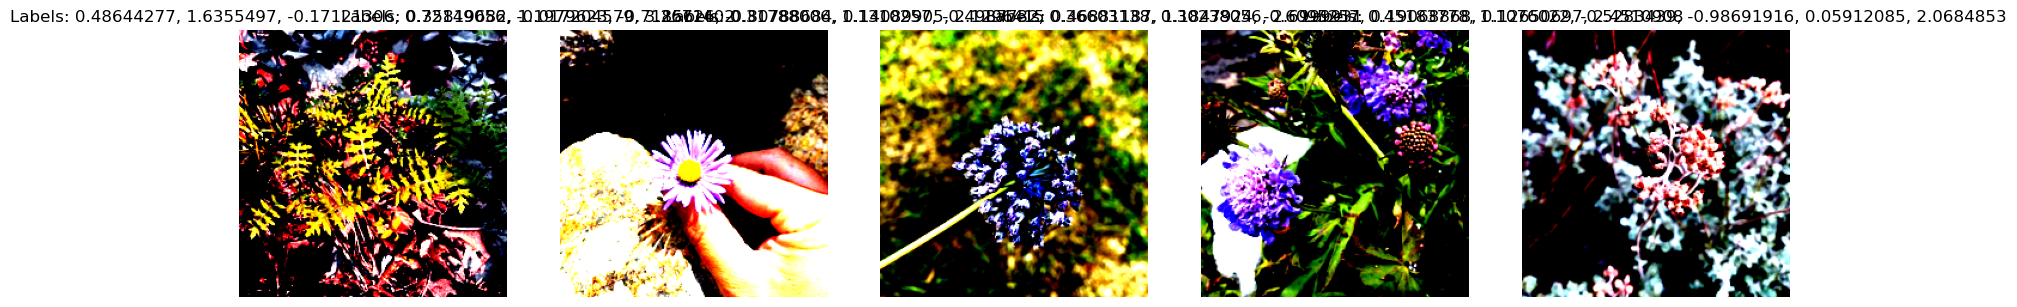

In [14]:
#visualize input images
def show_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 10))
    for idx, (image, label) in enumerate(zip(images, labels)):
        image = image.permute(1, 2, 0)  
        axes[idx].imshow(image)
        label_str = ", ".join([str(val) for val in label])  
        axes[idx].set_title(f"Labels: {label_str}")
        axes[idx].axis("off")
    plt.show()

num_images_to_display = 5
sample_indices = torch.randint(len(train_dataset), size=(num_images_to_display,))
sample_images = [train_dataset[i][0] for i in sample_indices]
sample_labels = [train_dataset[i][1] for i in sample_indices]

sample_labels_np = [label.numpy() for label in sample_labels]

show_images(sample_images, sample_labels_np)



In [15]:
#setup model
import torch.nn as nn
import tqdm as notebook_tqdm
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PlantModelResNet(nn.Module):
    def __init__(self, num_classes):
        super(PlantModelResNet, self).__init__()
        self.resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        return self.resnet(x)

class PlantModelCNN(nn.Module):
    def __init__(self, num_classes):
        super(PlantModelCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(64*56*56, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


#setup MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input = nn.Linear(in_features=input_dim, out_features=64)
        self.hidden_1 = nn.Linear(in_features=64, out_features=64)
        self.hidden_2 = nn.Linear(in_features=64, out_features=16)
        self.hidden_3 = nn.Linear(in_features=16, out_features=16)
        self.hidden_4 = nn.Linear(in_features=16, out_features=10)
        self.output = nn.Linear(in_features=10, out_features=output_dim)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = F.relu(self.input(x))
        x = self.dropout(x)
        x = F.relu(self.hidden_1(x))
        x = self.dropout(x)
        x = F.relu(self.hidden_2(x))
        x = self.dropout(x)
        x = F.relu(self.hidden_3(x))
        x = self.dropout(x)
        x = F.relu(self.hidden_4(x))
        x = self.output(x)
        return x
'''
class EnsembleModel(nn.Module):
    def __init__(self, cnn_model, tabular_model):
        super().__init__()
        self.cnn_model = cnn_model
        self.tabular_model = tabular_model
        self.linear = nn.Linear(12, 6)  # Combine 6 predictions from each model

    def forward(self, x_cnn, x_tabular):
        cnn_output = self.cnn_model(x_cnn)
        tabular_output = self.tabular_model(x_tabular)
        ensemble_input = torch.cat((cnn_output, tabular_output), dim=1)
        return self.linear(ensemble_input)
'''

'\nclass EnsembleModel(nn.Module):\n    def __init__(self, cnn_model, tabular_model):\n        super().__init__()\n        self.cnn_model = cnn_model\n        self.tabular_model = tabular_model\n        self.linear = nn.Linear(12, 6)  # Combine 6 predictions from each model\n\n    def forward(self, x_cnn, x_tabular):\n        cnn_output = self.cnn_model(x_cnn)\n        tabular_output = self.tabular_model(x_tabular)\n        ensemble_input = torch.cat((cnn_output, tabular_output), dim=1)\n        return self.linear(ensemble_input)\n'

In [16]:
#instantiate models
model = PlantModelResNet(config.num_classes).to(device)

mlp_model = MLP(train_tabular_data.get_input_dimensions(), train_tabular_data.get_output_dimensions()).to(device)
#ensemble_model = EnsembleModel(cnn_model, tabular_model).to(device)

Using cache found in C:\Users\ekabu/.cache\torch\hub\pytorch_vision_v0.6.0
C:\Users\ekabu\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ekabu\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
def train_model(model, train_loader, val_loader, test_loader, optimizer, criterion, num_epochs, checkpoint_path, best_model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #use mps for mac
    # device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)

    best_loss = float('inf')
    best_model_weights = model.state_dict()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 10)

        # Training phase
        model.train()
        train_loss = 0.0

        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_dataset)
        print(f"Train Loss: {train_loss:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item() * inputs.size(0)

            val_loss /= len(val_dataset)
            print(f"Val Loss: {val_loss:.4f}")

        # Save checkpoint
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }
        torch.save(checkpoint, f"{checkpoint_path}/checkpoint_epoch_{epoch}.pt")

        # Save the best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_weights = model.state_dict()

    # Load the best model weights
    model.load_state_dict(best_model_weights)

    # Save the best model after testing
    torch.save(model.state_dict(), best_model_path)

    # Testing phase
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item() * inputs.size(0)

        test_loss /= len(test_loader.dataset)
        print(f"Test Loss: {test_loss:.4f}")

    return model


In [18]:
def train_MLP_model(model, train_loader, val_loader, num_epochs=20, learning_rate=0.01):
    best_train_loss = float('inf')
    best_val_loss = float('inf')
    best_epoch = -1
    best_model_params = None

    train_losses = []
    val_losses = []

    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        # Train set
        for i, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)

            preds = model(X)
            loss = loss_function(preds, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Keep track of best iteration and loss
            if loss < best_train_loss:
                best_train_loss = loss

            # Append training loss to list
            train_losses.append(loss.item())

            # Print loss at certain intervals
            if (i + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        # Calculate loss on validation set after each epoch
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for (X, y) in val_loader:
                X, y = X.to(device), y.to(device)

                preds = model(X)
                loss = loss_function(preds, y)
                val_loss += loss.item()

        # Print validation loss after each epoch
        val_loss /= len(val_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

        # Append validation loss to list
        val_losses.append(val_loss)

        # Check if current validation loss is the best so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = (epoch + 1)
            # Save the model parameters
            best_model_params = model.state_dict()

    #load best paramters to the model            
    model.load_state_dict(best_model_params)

    # Print best iteration and loss
    print(f'Best epoch: {best_epoch}, Best train loss: {best_train_loss.item():.4f}, Best val loss: {best_val_loss:.4f}')
    
    return model, train_losses, val_losses

In [19]:
#function to train ensemble model
#....

In [20]:
# Plotting the loss curves
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Iter')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()
    plt.show()

In [26]:
#setup optimizer and loss function
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-5)
#loss function for resnet model
criterion = nn.MSELoss()

checkpoint_path = os.getcwd() + '/checkpoints'
best_model_path = os.getcwd() + '/best_model.pt'

model = train_model(model, train_loader, val_loader, val_loader, optimizer, criterion, config.EPOCHS, checkpoint_path, best_model_path)

#load the best model
model.load_state_dict(torch.load(best_model_path))

#save the test results
def save_test_results(model, test_loader, save_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #use mps for mac
    # device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)
    model.eval()

    test_results = []

    with torch.no_grad():
        for inputs, _ in notebook_tqdm.tqdm(test_loader):
            inputs = inputs.to(device)

            outputs = model(inputs)
            test_results.append(outputs.cpu().numpy())

    test_results = np.concatenate(test_results, axis=0)
    np.save(save_path, test_results)

save_path = 'test_results.npy'
save_test_results(model, val_loader, save_path)

#load the test results
test_results = np.load(save_path)
test_results[:5]




Epoch 1/1
----------


KeyboardInterrupt: 

In [ ]:
#calculate R2 score
#load best model
model.load_state_dict(torch.load(best_model_path))

# Assuming you have a test dataframe with 'id' column
test  =pd.read_csv(config.test_path)
test["image_path"] = config.test_image_path + test['id'].astype(str) + '.jpeg'
# Drop duplicates
test = test.drop_duplicates()

# Get image paths and labels for the test set
test_paths = test["image_path"].tolist()
class CustomTestDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        # Load and preprocess the image
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        return {"image": image}
# Assuming 'transform' is the same transformation you used during training
dataset_test = CustomTestDataset(test_paths, transform=val_transforms)

# Create a data loader for the test set
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [ ]:
model.eval()

# Lists to store predictions
cnn_predictions = []

for inputs in test_dataloader:
    images = inputs["image"].to('cuda')  # Move to the device (e.g., GPU) if available

    # Forward pass
    with torch.no_grad():
        outputs = model(images)

    predictions = outputs.cpu().numpy() if torch.cuda.is_available() else outputs.numpy()

    cnn_predictions.append(predictions)

# Concatenate predictions from all batches
cnn_predictions = np.concatenate(cnn_predictions, axis=0)

In [ ]:
#inverse output of column 2-6 since these were scaled using log10 scale.
cnn_predictions[:, 1:] = 10 ** cnn_predictions[:, 1:]

In [ ]:
# sub = pd.read_csv(config.sub)
# Assuming 'predictions_original_scale' is the array of predictions
#convert the predictions to pandas dataframe

sub = pd.DataFrame(predictions_original_scale, columns=config.PREDICTOR_NAMES)
sub['id'] = test['id'].values
sub = sub[['id', 'X4', 'X11', 'X18', 'X50', 'X26', 'X3112']]

sub.to_csv("submission.csv", index = False)
display(sub)

print(f'shape of submission file: {sub.shape}, num of inf values: {sub.isin([np.inf]).sum().sum()}')

In [23]:
#Train MLP model
mlp_model, train_losses, val_losses = train_MLP_model(mlp_model, train_tabular_loader, val_tabular_loader,
                                                      num_epochs=config.MLP_EPOCHS, learning_rate=0.001)

Epoch [1/30], Step [10/694], Loss: 2.1592
Epoch [1/30], Step [20/694], Loss: 2.0114
Epoch [1/30], Step [30/694], Loss: 2.3551
Epoch [1/30], Step [40/694], Loss: 2.2542
Epoch [1/30], Step [50/694], Loss: 1.9418
Epoch [1/30], Step [60/694], Loss: 1.8321
Epoch [1/30], Step [70/694], Loss: 1.5301
Epoch [1/30], Step [80/694], Loss: 1.2986
Epoch [1/30], Step [90/694], Loss: 1.1695
Epoch [1/30], Step [100/694], Loss: 0.8430
Epoch [1/30], Step [110/694], Loss: 0.9442
Epoch [1/30], Step [120/694], Loss: 0.8218
Epoch [1/30], Step [130/694], Loss: 0.9346
Epoch [1/30], Step [140/694], Loss: 0.8908
Epoch [1/30], Step [150/694], Loss: 0.7297
Epoch [1/30], Step [160/694], Loss: 0.7399
Epoch [1/30], Step [170/694], Loss: 0.5961
Epoch [1/30], Step [180/694], Loss: 0.6582
Epoch [1/30], Step [190/694], Loss: 0.6646
Epoch [1/30], Step [200/694], Loss: 0.7153
Epoch [1/30], Step [210/694], Loss: 0.6244
Epoch [1/30], Step [220/694], Loss: 0.6099
Epoch [1/30], Step [230/694], Loss: 0.6137
Epoch [1/30], Step [

Epoch [3/30], Step [560/694], Loss: 0.3202
Epoch [3/30], Step [570/694], Loss: 0.3154
Epoch [3/30], Step [580/694], Loss: 0.2614
Epoch [3/30], Step [590/694], Loss: 0.3259
Epoch [3/30], Step [600/694], Loss: 0.3005
Epoch [3/30], Step [610/694], Loss: 0.2868
Epoch [3/30], Step [620/694], Loss: 0.3084
Epoch [3/30], Step [630/694], Loss: 0.3094
Epoch [3/30], Step [640/694], Loss: 0.3023
Epoch [3/30], Step [650/694], Loss: 0.3332
Epoch [3/30], Step [660/694], Loss: 0.2844
Epoch [3/30], Step [670/694], Loss: 0.3062
Epoch [3/30], Step [680/694], Loss: 0.2874
Epoch [3/30], Step [690/694], Loss: 0.3258
Epoch [3/30], Validation Loss: 0.3238
Epoch [4/30], Step [10/694], Loss: 0.3487
Epoch [4/30], Step [20/694], Loss: 0.3050
Epoch [4/30], Step [30/694], Loss: 0.2320
Epoch [4/30], Step [40/694], Loss: 0.2671
Epoch [4/30], Step [50/694], Loss: 0.3204
Epoch [4/30], Step [60/694], Loss: 0.3936
Epoch [4/30], Step [70/694], Loss: 0.3306
Epoch [4/30], Step [80/694], Loss: 0.2994
Epoch [4/30], Step [90/6

Epoch [6/30], Step [390/694], Loss: 0.2617
Epoch [6/30], Step [400/694], Loss: 0.3076
Epoch [6/30], Step [410/694], Loss: 0.6574
Epoch [6/30], Step [420/694], Loss: 0.3385
Epoch [6/30], Step [430/694], Loss: 0.3141
Epoch [6/30], Step [440/694], Loss: 0.3310
Epoch [6/30], Step [450/694], Loss: 0.3297
Epoch [6/30], Step [460/694], Loss: 0.2962
Epoch [6/30], Step [470/694], Loss: 0.2770
Epoch [6/30], Step [480/694], Loss: 0.3243
Epoch [6/30], Step [490/694], Loss: 0.3366
Epoch [6/30], Step [500/694], Loss: 0.2771
Epoch [6/30], Step [510/694], Loss: 0.2542
Epoch [6/30], Step [520/694], Loss: 0.3961
Epoch [6/30], Step [530/694], Loss: 0.2759
Epoch [6/30], Step [540/694], Loss: 0.2812
Epoch [6/30], Step [550/694], Loss: 0.2732
Epoch [6/30], Step [560/694], Loss: 0.3769
Epoch [6/30], Step [570/694], Loss: 0.3417
Epoch [6/30], Step [580/694], Loss: 0.2571
Epoch [6/30], Step [590/694], Loss: 0.2793
Epoch [6/30], Step [600/694], Loss: 0.1713
Epoch [6/30], Step [610/694], Loss: 0.3323
Epoch [6/30

Epoch [9/30], Step [220/694], Loss: 0.2914
Epoch [9/30], Step [230/694], Loss: 0.3157
Epoch [9/30], Step [240/694], Loss: 0.2494
Epoch [9/30], Step [250/694], Loss: 0.2353
Epoch [9/30], Step [260/694], Loss: 0.6115
Epoch [9/30], Step [270/694], Loss: 0.3662
Epoch [9/30], Step [280/694], Loss: 0.3087
Epoch [9/30], Step [290/694], Loss: 0.3101
Epoch [9/30], Step [300/694], Loss: 0.2618
Epoch [9/30], Step [310/694], Loss: 0.2712
Epoch [9/30], Step [320/694], Loss: 0.4145
Epoch [9/30], Step [330/694], Loss: 0.3344
Epoch [9/30], Step [340/694], Loss: 0.3339
Epoch [9/30], Step [350/694], Loss: 0.3861
Epoch [9/30], Step [360/694], Loss: 0.2904
Epoch [9/30], Step [370/694], Loss: 0.2640
Epoch [9/30], Step [380/694], Loss: 0.3273
Epoch [9/30], Step [390/694], Loss: 0.2458
Epoch [9/30], Step [400/694], Loss: 0.3006
Epoch [9/30], Step [410/694], Loss: 0.2887
Epoch [9/30], Step [420/694], Loss: 0.2271
Epoch [9/30], Step [430/694], Loss: 0.3496
Epoch [9/30], Step [440/694], Loss: 0.2608
Epoch [9/30

Epoch [11/30], Validation Loss: 0.3136
Epoch [12/30], Step [10/694], Loss: 0.3003
Epoch [12/30], Step [20/694], Loss: 0.2815
Epoch [12/30], Step [30/694], Loss: 0.3316
Epoch [12/30], Step [40/694], Loss: 0.2753
Epoch [12/30], Step [50/694], Loss: 0.3358
Epoch [12/30], Step [60/694], Loss: 0.2911
Epoch [12/30], Step [70/694], Loss: 0.3407
Epoch [12/30], Step [80/694], Loss: 0.3157
Epoch [12/30], Step [90/694], Loss: 0.3033
Epoch [12/30], Step [100/694], Loss: 0.2866
Epoch [12/30], Step [110/694], Loss: 0.3240
Epoch [12/30], Step [120/694], Loss: 0.3288
Epoch [12/30], Step [130/694], Loss: 0.3190
Epoch [12/30], Step [140/694], Loss: 0.2029
Epoch [12/30], Step [150/694], Loss: 0.3258
Epoch [12/30], Step [160/694], Loss: 0.2792
Epoch [12/30], Step [170/694], Loss: 0.2531
Epoch [12/30], Step [180/694], Loss: 0.3351
Epoch [12/30], Step [190/694], Loss: 0.3164
Epoch [12/30], Step [200/694], Loss: 0.2716
Epoch [12/30], Step [210/694], Loss: 0.3601
Epoch [12/30], Step [220/694], Loss: 0.2718
Ep

Epoch [14/30], Step [540/694], Loss: 0.2945
Epoch [14/30], Step [550/694], Loss: 0.2926
Epoch [14/30], Step [560/694], Loss: 0.3055
Epoch [14/30], Step [570/694], Loss: 0.3227
Epoch [14/30], Step [580/694], Loss: 0.2357
Epoch [14/30], Step [590/694], Loss: 0.2062
Epoch [14/30], Step [600/694], Loss: 0.3178
Epoch [14/30], Step [610/694], Loss: 0.3211
Epoch [14/30], Step [620/694], Loss: 0.2992
Epoch [14/30], Step [630/694], Loss: 0.3242
Epoch [14/30], Step [640/694], Loss: 0.3349
Epoch [14/30], Step [650/694], Loss: 0.3115
Epoch [14/30], Step [660/694], Loss: 0.3075
Epoch [14/30], Step [670/694], Loss: 0.2985
Epoch [14/30], Step [680/694], Loss: 0.3660
Epoch [14/30], Step [690/694], Loss: 0.3542
Epoch [14/30], Validation Loss: 0.3127
Epoch [15/30], Step [10/694], Loss: 0.2554
Epoch [15/30], Step [20/694], Loss: 0.2621
Epoch [15/30], Step [30/694], Loss: 0.2590
Epoch [15/30], Step [40/694], Loss: 0.3574
Epoch [15/30], Step [50/694], Loss: 0.2894
Epoch [15/30], Step [60/694], Loss: 0.3283

Epoch [17/30], Step [390/694], Loss: 0.2983
Epoch [17/30], Step [400/694], Loss: 0.2949
Epoch [17/30], Step [410/694], Loss: 0.2907
Epoch [17/30], Step [420/694], Loss: 0.2861
Epoch [17/30], Step [430/694], Loss: 0.3099
Epoch [17/30], Step [440/694], Loss: 0.4184
Epoch [17/30], Step [450/694], Loss: 0.2717
Epoch [17/30], Step [460/694], Loss: 0.2809
Epoch [17/30], Step [470/694], Loss: 0.4079
Epoch [17/30], Step [480/694], Loss: 0.3558
Epoch [17/30], Step [490/694], Loss: 0.2968
Epoch [17/30], Step [500/694], Loss: 0.2928
Epoch [17/30], Step [510/694], Loss: 0.2686
Epoch [17/30], Step [520/694], Loss: 0.2827
Epoch [17/30], Step [530/694], Loss: 0.3690
Epoch [17/30], Step [540/694], Loss: 0.2679
Epoch [17/30], Step [550/694], Loss: 0.3346
Epoch [17/30], Step [560/694], Loss: 0.2779
Epoch [17/30], Step [570/694], Loss: 0.3279
Epoch [17/30], Step [580/694], Loss: 0.3878
Epoch [17/30], Step [590/694], Loss: 0.3325
Epoch [17/30], Step [600/694], Loss: 0.3160
Epoch [17/30], Step [610/694], L

Epoch [20/30], Step [220/694], Loss: 0.4229
Epoch [20/30], Step [230/694], Loss: 0.2701
Epoch [20/30], Step [240/694], Loss: 0.3099
Epoch [20/30], Step [250/694], Loss: 0.2603
Epoch [20/30], Step [260/694], Loss: 0.2737
Epoch [20/30], Step [270/694], Loss: 0.3057
Epoch [20/30], Step [280/694], Loss: 0.3298
Epoch [20/30], Step [290/694], Loss: 0.7203
Epoch [20/30], Step [300/694], Loss: 0.2721
Epoch [20/30], Step [310/694], Loss: 0.2753
Epoch [20/30], Step [320/694], Loss: 0.2342
Epoch [20/30], Step [330/694], Loss: 0.3175
Epoch [20/30], Step [340/694], Loss: 0.2877
Epoch [20/30], Step [350/694], Loss: 0.3075
Epoch [20/30], Step [360/694], Loss: 0.3271
Epoch [20/30], Step [370/694], Loss: 0.2870
Epoch [20/30], Step [380/694], Loss: 0.3380
Epoch [20/30], Step [390/694], Loss: 0.3080
Epoch [20/30], Step [400/694], Loss: 0.3258
Epoch [20/30], Step [410/694], Loss: 0.2535
Epoch [20/30], Step [420/694], Loss: 0.2655
Epoch [20/30], Step [430/694], Loss: 0.2919
Epoch [20/30], Step [440/694], L

Epoch [23/30], Step [10/694], Loss: 0.2662
Epoch [23/30], Step [20/694], Loss: 0.2437
Epoch [23/30], Step [30/694], Loss: 0.2473
Epoch [23/30], Step [40/694], Loss: 0.3092
Epoch [23/30], Step [50/694], Loss: 0.3018
Epoch [23/30], Step [60/694], Loss: 0.2648
Epoch [23/30], Step [70/694], Loss: 0.2980
Epoch [23/30], Step [80/694], Loss: 0.4728
Epoch [23/30], Step [90/694], Loss: 0.3036
Epoch [23/30], Step [100/694], Loss: 0.2978
Epoch [23/30], Step [110/694], Loss: 0.2704
Epoch [23/30], Step [120/694], Loss: 0.2817
Epoch [23/30], Step [130/694], Loss: 0.3190
Epoch [23/30], Step [140/694], Loss: 0.4023
Epoch [23/30], Step [150/694], Loss: 0.3278
Epoch [23/30], Step [160/694], Loss: 0.3206
Epoch [23/30], Step [170/694], Loss: 0.2948
Epoch [23/30], Step [180/694], Loss: 0.3273
Epoch [23/30], Step [190/694], Loss: 0.3427
Epoch [23/30], Step [200/694], Loss: 0.2188
Epoch [23/30], Step [210/694], Loss: 0.3025
Epoch [23/30], Step [220/694], Loss: 0.3110
Epoch [23/30], Step [230/694], Loss: 0.20

Epoch [25/30], Step [510/694], Loss: 0.3611
Epoch [25/30], Step [520/694], Loss: 0.3299
Epoch [25/30], Step [530/694], Loss: 0.3122
Epoch [25/30], Step [540/694], Loss: 0.2303
Epoch [25/30], Step [550/694], Loss: 0.2557
Epoch [25/30], Step [560/694], Loss: 0.3762
Epoch [25/30], Step [570/694], Loss: 0.2900
Epoch [25/30], Step [580/694], Loss: 0.2755
Epoch [25/30], Step [590/694], Loss: 0.2557
Epoch [25/30], Step [600/694], Loss: 0.3794
Epoch [25/30], Step [610/694], Loss: 0.2237
Epoch [25/30], Step [620/694], Loss: 0.3120
Epoch [25/30], Step [630/694], Loss: 0.2587
Epoch [25/30], Step [640/694], Loss: 0.3705
Epoch [25/30], Step [650/694], Loss: 0.3627
Epoch [25/30], Step [660/694], Loss: 0.3509
Epoch [25/30], Step [670/694], Loss: 0.2648
Epoch [25/30], Step [680/694], Loss: 0.2272
Epoch [25/30], Step [690/694], Loss: 0.3365
Epoch [25/30], Validation Loss: 0.3039
Epoch [26/30], Step [10/694], Loss: 0.3595
Epoch [26/30], Step [20/694], Loss: 0.2694
Epoch [26/30], Step [30/694], Loss: 0.2

Epoch [28/30], Step [340/694], Loss: 0.2797
Epoch [28/30], Step [350/694], Loss: 0.2317
Epoch [28/30], Step [360/694], Loss: 0.2329
Epoch [28/30], Step [370/694], Loss: 0.2670
Epoch [28/30], Step [380/694], Loss: 0.2872
Epoch [28/30], Step [390/694], Loss: 0.2938
Epoch [28/30], Step [400/694], Loss: 0.2790
Epoch [28/30], Step [410/694], Loss: 0.3366
Epoch [28/30], Step [420/694], Loss: 0.2655
Epoch [28/30], Step [430/694], Loss: 0.2959
Epoch [28/30], Step [440/694], Loss: 0.3035
Epoch [28/30], Step [450/694], Loss: 0.2739
Epoch [28/30], Step [460/694], Loss: 0.3117
Epoch [28/30], Step [470/694], Loss: 0.2679
Epoch [28/30], Step [480/694], Loss: 0.2749
Epoch [28/30], Step [490/694], Loss: 0.3688
Epoch [28/30], Step [500/694], Loss: 0.2315
Epoch [28/30], Step [510/694], Loss: 0.3091
Epoch [28/30], Step [520/694], Loss: 0.3648
Epoch [28/30], Step [530/694], Loss: 0.2522
Epoch [28/30], Step [540/694], Loss: 0.2599
Epoch [28/30], Step [550/694], Loss: 0.2973
Epoch [28/30], Step [560/694], L

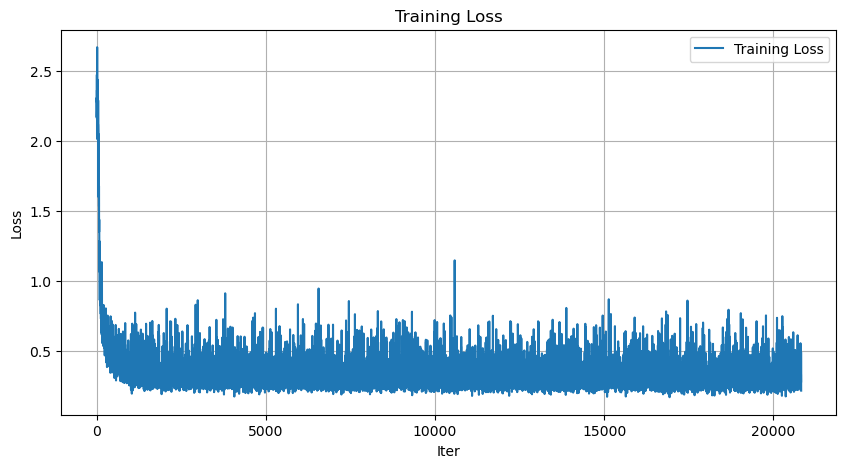

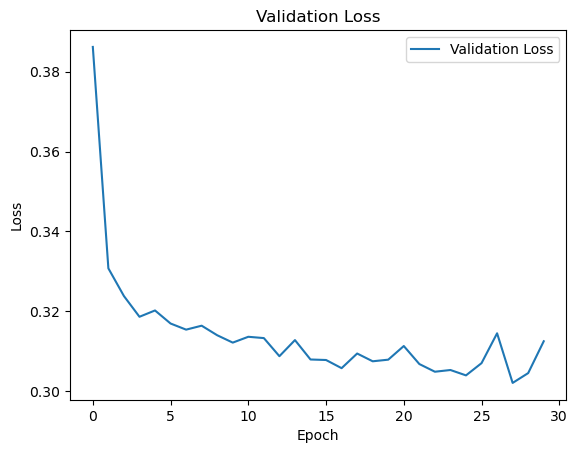

In [24]:
plot_loss(train_losses, val_losses)

In [25]:
#predict based on tabular test data
mlp_model.eval()
test_tabular_data = test_tabular_data.to(device)
with torch.no_grad():
    mlp_predictions = mlp_model(test_tabular_data)
    
#inverse output of column 2-6 since these were scaled using log10 scale.
mlp_predictions[:, 1:] = 10 ** mlp_predictions[:, 1:]
print(f"prediction size: {mlp_predictions.shape}, \nprediction result : {mlp_predictions}")

#Move predictions tensor to CPU
predictions_np = mlp_predictions.cpu().numpy()

#generate df for predictions and load to .csv
predictions_df = pd.DataFrame({'id': test['id']})

for i, col_name in enumerate(config.PREDICTOR_NAMES):
    predictions_df[col_name] = predictions_np[:, i]
    
print(f'predicton sample: {predictions_df.head(2)}')
predictions_df.to_csv('prediction_tabular.csv', index=False)

prediction size: torch.Size([6545, 6]), 
prediction result : tensor([[5.4048e-01, 9.7643e+00, 8.5757e-01, 9.4022e-01, 1.4376e+00, 1.9286e+02],
        [4.1854e-01, 1.6349e+01, 2.3227e-01, 1.0430e+00, 1.4646e+00, 2.8200e+02],
        [4.6258e-01, 1.4675e+01, 3.2728e-01, 1.1616e+00, 1.5786e+00, 3.0519e+02],
        ...,
        [4.0518e-01, 2.1726e+01, 4.7624e-01, 1.3049e+00, 1.1217e+00, 7.3373e+02],
        [4.2290e-01, 1.7611e+01, 2.9948e-01, 1.0605e+00, 1.3706e+00, 3.7824e+02],
        [5.5366e-01, 1.2532e+01, 2.8379e+00, 1.0909e+01, 1.4816e+00, 1.3105e+03]],
       device='cuda:0')
predicton sample:           id        X4        X11       X18       X50       X26       X3112
0  201238668  0.540481   9.764288  0.857567  0.940220  1.437593  192.856354
1  202310319  0.418540  16.348764  0.232268  1.043017  1.464567  281.998352


In [ ]:
plot_loss(train_losses, val_losses)